## Libs


In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
import sklearn.neural_network as sknn
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.ensemble import RandomForestRegressor
jax.config.update('jax_enable_x64', True)
# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.base_models import ICNNObsDecoder
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config
 

## Data Loading

In [2]:

rng = np.random.RandomState(42)

X_diabetes, y_diabetes = load_diabetes(return_X_y=True)
X_california, y_california = fetch_california_housing(return_X_y=True)
X_california = X_california[:3000]
y_california = y_california[:3000]
X_diabetes = X_diabetes[:3000]
y_diabetes = y_diabetes[:3000]


def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing


X_miss_california, y_miss_california = add_missing_values(X_california, y_california)
X_miss_diabetes, y_miss_diabetes = add_missing_values(X_diabetes, y_diabetes)

In [3]:
X_miss_california.shape, X_miss_diabetes.shape

((3000, 8), (442, 10))

### Split

In [4]:
rng = np.random.RandomState(0)

from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


In [5]:
from typing import Literal, Callable, Tuple
from sklearn.model_selection import KFold

import equinox as eqx
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import optax

class MLPRegressor(eqx.Module):
    mlp: eqx.nn.MLP
    optimiser: optax.GradientTransformation = eqx.static_field()
    lr: float = eqx.static_field()
    alpha: float = eqx.static_field()
    loss_fn: Callable[[jnp.ndarray], jnp.ndarray] = eqx.static_field()
    batch_size: int = eqx.static_field()
    max_iters: int = eqx.static_field()
    seed: int = eqx.static_field()

    def __init__(self, input_size: int, output_size: int, hidden_size: int, depth: int,
                 activation: Literal['relu', 'tanh', 'sigmoid', 'elu', 'softplus', 'leaky_relu'], batch_size: int,
                 lr: float = 1e-3, alpha: float = 1e-5, loss_fn: Literal['mse', 'mae'] = 'mse',
                 max_iters: int = 100,
                 seed: int = 0):
        super().__init__()
        if activation == 'relu':
            activation_f = jnn.relu
        elif activation == 'tanh':
            activation_f = jnn.tanh
        elif activation == 'sigmoid':
            activation_f = jnn.sigmoid
        elif activation == 'softplus':
            activation_f = jnn.softplus
        elif activation == 'elu':
            activation_f = jnn.elu
        elif activation == 'leaky_relu':
            activation_f = lambda x: jnn.leaky_relu(x, negative_slope=0.01)
        else:
            activation_f = lambda x: x

        if loss_fn == 'mse':
            self.loss_fn = jnp.square
        elif loss_fn == 'mae':
            self.loss_fn = jnp.abs
        else:
            raise ValueError(f"Unknown loss function {loss_fn}")

        self.mlp = eqx.nn.MLP(input_size, output_size, hidden_size, depth, activation=activation_f,
                              key=jr.PRNGKey(seed),
                              use_bias=True, use_final_bias=True)
        self.optimiser = optax.adam(lr)
        self.lr = lr
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_iters = max_iters
        self.seed = seed

    @eqx.filter_jit
    def loss(self, batch_X: jnp.ndarray, batch_y: jnp.ndarray) -> jnp.ndarray:
        y_hat = eqx.filter_vmap(self.predict)(batch_X)
        return jnp.mean(self.loss_fn(y_hat - batch_y))

    @property
    def weights_list(self):
        return list(l.weight for l in self.mlp.layers)

    @eqx.filter_value_and_grad
    def loss_grad(self, batch_X: jnp.ndarray, batch_y: jnp.ndarray):
        L = self.loss(batch_X, batch_y)
        if self.alpha > 0:
            L += self.alpha * sum(jnp.sum(jnp.square(w)) for w in self.weights_list) / (2 * len(batch_X))
        return L

    @eqx.filter_jit
    def make_step(self, opt_state, batch_X: jnp.ndarray, batch_y: jnp.ndarray) -> Tuple[
        jnp.ndarray, "MLPRegressor", optax.OptState]:
        loss, grads = self.loss_grad(batch_X, batch_y)
        updates, opt_state = self.optimiser.update(grads, opt_state,
                                                   params=eqx.filter(self, eqx.is_inexact_array))
        return loss, eqx.apply_updates(self, updates), opt_state

    @staticmethod
    def dataloader(arrays, batch_size, *, key):
        dataset_size = arrays[0].shape[0]
        indices = jnp.arange(dataset_size)
        while True:
            perm = jr.permutation(key, indices)
            (key,) = jr.split(key, 1)
            start = 0
            end = batch_size
            while end < dataset_size:
                batch_perm = perm[start:end]
                yield tuple(array[batch_perm] for array in arrays)
                start = end
                end = start + batch_size

    def fit(self, X: jnp.ndarray, y: jnp.ndarray):
        model = self
        opt_state = self.optimiser.init(eqx.filter(model, eqx.is_inexact_array))
        train_batches = self.dataloader((X, y), self.batch_size, key=jr.PRNGKey(self.seed))
        progress = tqdm(range(self.max_iters), leave=False)
        for step, (batch_X, batch_y) in zip(progress, train_batches):
            loss, model, opt_state = model.make_step(opt_state, batch_X, batch_y)
            progress.set_description(f"Loss: {loss:.4f}")

        return model

    @eqx.filter_jit
    def predict(self, X: jnp.ndarray):
        if jnp.ndim(X) == 1:
            X = X[None, :]
        return eqx.filter_vmap(self.mlp)(X)


class MLPRegressorICNN(MLPRegressor):
    imputer: ICNNObsDecoder

    def __init__(self, input_size: int, output_size: int, hidden_size: int, depth: int,
                 activation: Literal['relu', 'tanh', 'sigmoid'], batch_size: int,
                 imputer_hidden_size_multiplier: int = 3, imputer_depth: int = 5,
                 lr: float = 1e-3, alpha: float = 1e-5, loss_fn: Literal['mse', 'mae'] = 'mse',
                 max_iters: int = 100,
                 seed: int = 0):
        super().__init__(input_size, output_size, hidden_size, depth, activation, batch_size, lr, alpha, loss_fn,
                         max_iters, seed)
        self.imputer = ICNNObsDecoder(observables_size=input_size, state_size=0,
                                      hidden_size_multiplier=imputer_hidden_size_multiplier,
                                      depth=imputer_depth, key=jr.PRNGKey(seed))

    @eqx.filter_jit
    def impute(self, X: jnp.ndarray):
        if jnp.ndim(X) == 1:
            X = X[None, :]
        M = jnp.where(jnp.isnan(X), False, True)
        X = jnp.nan_to_num(X)
        X, aux = eqx.filter_vmap(self.imputer.partial_input_optimise)(X, M)
        return X

    @eqx.filter_jit
    def predict(self, X: jnp.ndarray):
        if jnp.ndim(X) == 1:
            X = X[None, :]
        X = self.impute(X)
        return eqx.filter_vmap(self.mlp)(X)


In [59]:

def get_mlp_regressor(X):
    return MLPRegressor(input_size=X.shape[1],
                         output_size=1, hidden_size=X.shape[1]//2,
                         alpha=0., depth=1, activation='elu', batch_size=32, max_iters=5000, lr=1e-3)


# def get_sklearn_mlp_regressor(X):
#     return sknn.MLPRegressor(hidden_layer_sizes=(X.shape[1], )*3,
#                              solver='adam',
#                          alpha=0., activation='leaky_relu', batch_size=32, max_iter=1000, learning_rate_init=1e-3)


def get_rf_regressor(X = None):
    return RandomForestRegressor(random_state=0)

def get_mlp_icnn_regressor(X):
    return MLPRegressorICNN(input_size=X.shape[1],
                         output_size=1, hidden_size=X.shape[1]//2,
                         alpha=0., depth=1, activation='elu', batch_size=32, max_iters=5000, lr=1e-3)

def get_impute_regress_scores(model, X_missing_train, y_train, X_missing_test, y_test):
    if isinstance(model, tuple):
        model, imputer = model
        imputer = imputer.fit(X_missing_train)
        X_full_hat_train = imputer.transform(X_missing_train)
        X_full_hat_test = imputer.transform(X_missing_test)
        model = model.fit(X_full_hat_train, y_train)
        return {'train': np.mean(np.square(model.predict(X_full_hat_train) - y_train)),  
                'test': np.mean(np.square(model.predict(X_full_hat_test) - y_test))}
    else:
        model = model.fit(X_missing_train, y_train)
        return {'train': np.mean(np.square(model.predict(X_missing_train) - y_train)),  
                'test': np.mean(np.square(model.predict(X_missing_test) - y_test))}

def get_imput_regress_scores_cv(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    train_scores = []
    test_scores = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scores = get_impute_regress_scores(model, X_train, y_train, X_test, y_test)
        train_scores.append(scores['train'])
        test_scores.append(scores['test'])

    return pd.DataFrame({'split': ['TRAIN'] * len(train_scores) +  ['TEST'] * len(test_scores),
                        'MSE': train_scores + test_scores,
                        'Fold': list(range(len(train_scores))) + list(range(len(test_scores)))})



In [58]:
imputers =  {
    # 'zero-imputer': SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    # 'mean-imputer': SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn-imputer': KNNImputer(missing_values=np.nan),
    # 'iter-imputer': IterativeImputer(
    #     missing_values=np.nan,
    #     add_indicator=False,
    #     random_state=0,
    #     n_nearest_features=5,
    #     max_iter=5,
    #     sample_posterior=True,
    # )
}

dfs = []
for (ds_name, (X, y)) in zip(['California',
                              #'Diabetes'
                             ],  [(X_miss_california, y_miss_california), 
                                  (X_miss_diabetes, y_miss_diabetes)
                                 ]):
    for model_name, model in [('mlp', get_mlp_regressor(X)), 
                              ('rf', get_rf_regressor())
                             ]:
        for imputer_name, imputer in imputers.items():
            res = get_imput_regress_scores_cv((model,imputer), X, y)
            res['Dataset'] = ds_name
            res['Imputer'] = imputer_name
            res['Model'] = model_name
            dfs.append(res)



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
resicnn = get_imput_regress_scores_cv(get_mlp_icnn_regressor(X_miss_diabetes), X_miss_diabetes, y_miss_diabetes)

  0%|          | 0/5000 [00:00<?, ?it/s]

<Axes: xlabel='MSE', ylabel='Model'>

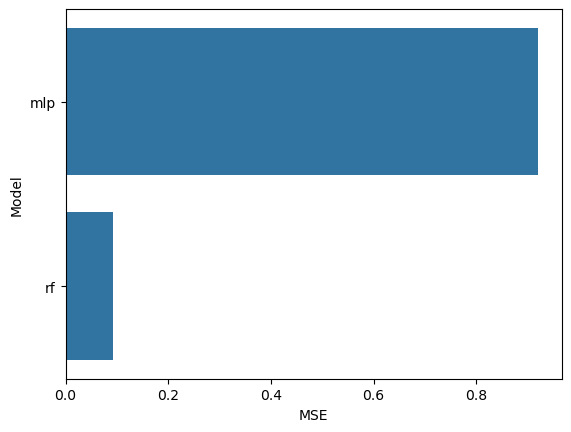

In [56]:
import seaborn as sns
results = pd.concat(dfs)


sns.barplot(results[(results.Dataset == 'California')], 
            x="MSE", y="Model", errorbar=None#"sd"
           )


In [14]:
claifornia_imputer = ICNNObsDecoder(observables_size=X_miss_california.shape[1], state_size=0,  hidden_size_multiplier=3, depth=10, key=jrandom.PRNGKey(0))
diabetes_imputer = ICNNObsDecoder(observables_size=X_miss_diabetes.shape[1], state_size=0,  hidden_size_multiplier=3, depth=10, key=jrandom.PRNGKey(0))

## Training

In [ ]:
california_scores.append(get_scores_for_icnn_imputer(claifornia_imputer,  X_miss_california, X_california))
diabetes_scores.append(get_scores_for_icnn_imputer(diabetes_imputer,  X_miss_diabetes, X_diabetes))
x_labels.append("ICNN Imputation")

In [ ]:
california_scores, california_scores_per_feature = zip(*california_scores)
diabetes_scores, diabetes_scores_per_feature = zip(*diabetes_scores)


In [ ]:
results = pd.DataFrame({'Diabetes': diabetes_scores, #'California': california_scores, 
                        'Method': x_labels})
results

In [ ]:
cal_features = [f'feature_{i}' for i in range(len(california_scores_per_feature[0]))]
diab_features = [f'feature_{i}' for i in range(len(diabetes_scores_per_feature[0]))]
cal_features_res = pd.DataFrame(dict(zip(x_labels, california_scores_per_feature)), index=cal_features)

In [ ]:
cal_features_res